In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#import tensorflow.compat.v1 as tf
import tensorflow as tf
import tensorflow_probability as tfp
import os
print(tf.executing_eagerly())
 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
#tf.compat.v1.disable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from preprocessing.data_loader import prepare_data
import joblib
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm

True


In [7]:
PATH = "/home/moritz/Data/Task03_Liver"
RES = 256
RES_Z = 64
CROP_HEIGHT = 16

X_train_partial, y_train_partial, X_val, y_val, X_test, y_test = prepare_data(PATH,
                                                                                res=RES,
                                                                                res_z=RES_Z,
                                                                                crop_height=CROP_HEIGHT,
                                                                                num_samples=50)


  0%|          | 0/50 [00:00<?, ?it/s]

... preparing data
... importing training data
... importing labels 
... preparing training data and labels(seg)


100%|██████████| 50/50 [05:58<00:00,  7.18s/it]


... total amount of training data: 50
... total amount of labels: 50

train set: 35 scans and 35 label volumes
test set: 15 scans and 15 label volumes
train set was split into partial train set: 31 scans and 31 label volumes
validation set: 4 scans and 4 label volumes
... converting data to 2D slices
... finished preparing data


In [4]:
X_train_partial = joblib.load("./serialized/data/liver/x_train_50.lib")
y_train_partial = joblib.load("./serialized/data/liver/y_train_50.lib")
X_val = joblib.load("./serialized/data/liver/x_val_50.lib")
y_val = joblib.load("./serialized/data/liver/y_val_50.lib")
X_test = joblib.load("./serialized/data/liver/x_test_50.lib")
y_test = joblib.load("./serialized/data/liver/y_test_50.lib")

In [5]:
y_train_partial = y_train_partial.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

In [141]:
dice_l = sm.losses.bce_dice_loss
dice_c = sm.metrics.f1_score

negloglik = lambda y, rv_y: -rv_y.log_prob(y) + dice_l(y, rv_y)

In [143]:
from models.MoNet import getMoNet
model = getMoNet(input_shape=(256, 256, 1), output_classes=1)
#model.compile(loss=dice_l,
#              optimizer='adam', metrics=[dice_c, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], experimental_run_tf_function=False)

In [144]:
bern_monet = tf.keras.Sequential([
    model,
    tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Bernoulli(probs=t)),
])

In [145]:
bern_monet.output.shape

TensorShape([None, 256, 256, 1])

In [146]:
"""bern_monet = tf.keras.Sequential([
    model,
    tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.MultivariateNormalDiagPlusLowRank(loc=t[..., 0],
                                                                    scale_diag=1e-3 + tf.math.softplus(0.05 * t[...,1]))),
])"""

'bern_monet = tf.keras.Sequential([\n    model,\n    tfp.layers.DistributionLambda(\n      lambda t: tfp.distributions.MultivariateNormalDiagPlusLowRank(loc=t[..., 0],\n                                                                    scale_diag=1e-3 + tf.math.softplus(0.05 * t[...,1]))),\n])'

In [148]:
bern_monet.compile(loss=negloglik,
              optimizer='adam', metrics=[dice_c, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], experimental_run_tf_function=False)

In [149]:
%reload_ext tensorboard
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y_%m_%d-%H:%M:%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
bern_monet.fit(X_train_partial[..., None], y_train_partial[..., None],
          epochs=40,
          validation_data=(X_val[..., None], y_val[..., None]),
          callbacks=[])

In [151]:
for i in range(20):
    y_probas = [bern_monet.predict(X_test[None, 0, ..., None]) for i in range(100)]
y_probas = np.stack(y_probas)

NameError: name 'tqdm' is not defined

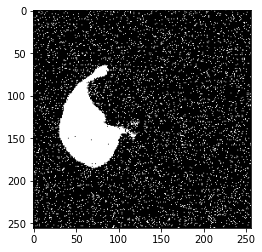

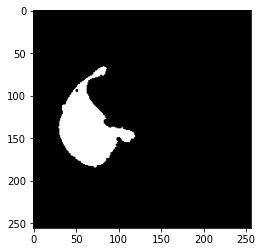

In [85]:
plt.imshow(t.squeeze(), cmap='gray')
plt.show()
plt.imshow(y_test[0], cmap='gray')
plt.show()

In [120]:
x = bern_monet(tf.ones((16, 256, 256, 1)))

In [121]:
s = x.sample()

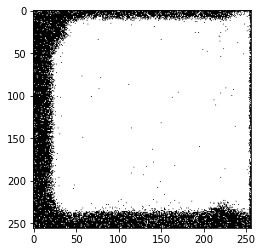

In [122]:
plt.imshow(s[1], cmap='gray')

In [17]:
from models.bayesian_MoNet import getMoNet
model = getMoNet(input_shape=(256, 256, 1), output_classes=1)
model.compile(loss=dice_l,
              optimizer='adam', metrics=[dice_c, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], experimental_run_tf_function=False)
model.load_weights("./serialized/weights/bayesian_monet.h5")

In [18]:
t = model.predict(X_test[..., None], batch_size=16)

(array([   53.,   483.,  3097.,  9036., 10603., 13810., 20598.,  7250.,
          531.,    75.]),
 array([0.07562137, 0.08400697, 0.09239256, 0.10077817, 0.10916377,
        0.11754937, 0.12593497, 0.13432057, 0.14270617, 0.15109177,
        0.15947737], dtype=float32),
 <BarContainer object of 10 artists>)

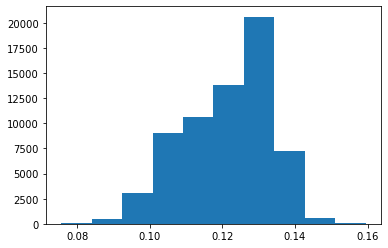

In [26]:
plt.hist(t[3].flatten())

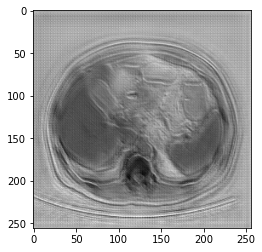

In [25]:
plt.imshow(normalise(t[3, ..., 0])*255, cmap='gray')

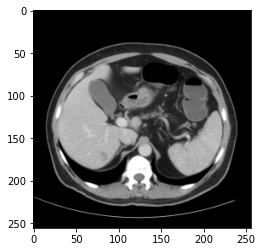

In [23]:
plt.imshow(X_test[3]*255, cmap='gray')